# Chapter 3 - Classification

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

## MNIST

In [3]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist["data"], mnist["target"]

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

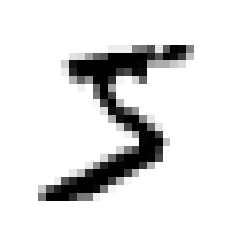

In [7]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

We are able to take the 784 different features of each image and reshape into a 28x28 array to print out the image. We can than see the label with the 'y' value.

In [8]:
y[0]

'5'

Currently the lable is a string, but we can cast 'y' to integers:

In [9]:
y = y.astype(np.uint8)

But before moving further along we should split the data into a training set (first 60,000 images) and test set (last 10,000 images).

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

Let's make the problem smaller and focus only on one number

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now we can use the SGDClassifier to detect images of the number 5:

In [13]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

#### Mearusing Accurasy Using Cross-Validation

In [14]:
# StraitfiedKFold class performs a stratisfied sampling
# At each iteration the code creates a clone of the classifier
# Trains that clone on the training folds
# And makes predictions on the test fold

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

C:\Users\jaola\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


Now we can use the `cross_val_score()` to evalueate the `SDGClassifier` model using K-fold cross-validation

In [15]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

We get an accuraci rating of above 95% with thsi classifier, but let's see how well we do with a 'dumb' classifier that classifies every single image in the "not-5" class:

In [16]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

This has over 90% accuracy simply because about 10% of the images are 5s, so if you always guess *not* a 5, you will be correct about 90% of the time.

#### Confusion Matrix

The *Confusion Matrix* counts how often an instance of class A is classified as class B.

First we need a set of predictions to compare to the actual targets. We don't want to use the test set for this (we only want to use it at the very end of the project). Instead we can use the `cross_val_predict()` function

In [18]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

The top row is all non-5 images, with the correcly predicted ones on the left (53892) and images wrongly classified as 5 on the right (687). The second row has false negatives on the left (1891) and correctly identified 5s (*true positives*) on the right (3530).

We can show how a perfect classifier gives back the confusion matrix by pretending that we have reach perfection:

In [20]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

#### Precision and Recall

In [21]:
precision_score(y_train_5, y_train_pred) #percentage of images represented as 5s were of 5s

0.8370879772350012

In [22]:
recall_score(y_train_5, y_train_pred) #percentage of times the program identifies the image as a 5 it is correct

0.6511713705958311

The F1 score combines the two scores, `2*((precision*recall)/(precision+recall))`.

This score is not always a good indicator of your predictions, as somethimes you don't mind a low recall rate but need to achieve a high precision (Identifying kid friendly videos on youtube), and other times you need it to be the other way around (security guards don't mind getting false alerts but want to catch all shoplifters). 

Unfortunately, we can not have it both ways. Increasing the precision decreases the recall, and vice versa.

In [23]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### Precision/Recall Tradeoff

If we use the `decision_function()`, instead of `predict()`, we can acseess the decision score that makes those decisions.

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

[2164.22030239]


array([ True])

If the threshold is 0 it gives back the same results as the `predict()` method. 

In [25]:
threshold = 8000
y_some_digit_pred = (y_scores>threshold)
y_some_digit_pred

array([False])

The classifier can identify the image correctly as a 5 when the threshold is set to 0. When increased to 8000 it decreases the recall but might miss a few images of 5s.

So how do we decide on the threashold? we can use the `cross_val_predict()` function again, but specify that we want it to return decision scores instead of predictions.

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

Now we can compute precision and recall for all possible threasholds using the `prediction_recall_curve()` function:

In [27]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

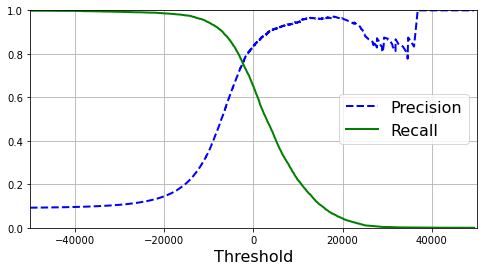

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



#recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
#threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
#plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
#plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
#plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
#plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
#save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

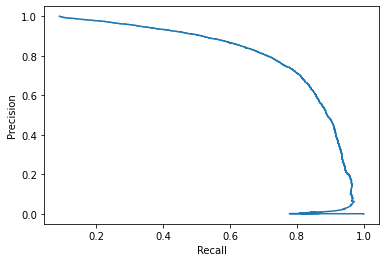

In [31]:
plt.plot(precisions, recalls);
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.show()

In [32]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [33]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [34]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [35]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

#### The ROC Curve

In [36]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [37]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label = label)
    plt.plot([0,1], [0,1], 'k--')
    plt.ylabel("True Positive Rate (Recall)")
    plt.xlabel("False Positive Rate")
    plt.grid()

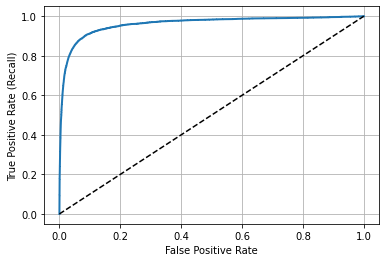

In [38]:
plot_roc_curve(fpr, tpr)
plt.show()

In [39]:
# Calculate area under curve
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Now let's train a `RandomForestClassifier` and compare its ROC curve to the `SDGClassifier`

In [40]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [41]:
#Changing from probabilities to scores
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

<function matplotlib.pyplot.show(close=None, block=None)>

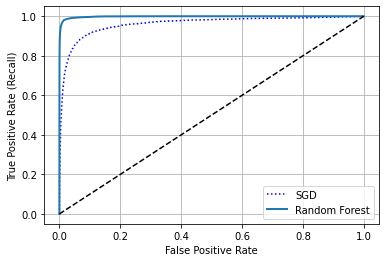

In [42]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show

In [43]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

If we use a binary classification algorithm for a multi classification task, it utilises a One-Vs-All method.

In [44]:
%%time
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

Wall time: 2min 46s


array([3], dtype=uint8)

In [45]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [46]:
np.argmax(some_digit_scores)

3

In [47]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [48]:
sgd_clf.classes_[5]

5

We can manually tell it to use a One-vs-One method. This is a lot faster

In [49]:
%%time
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

Wall time: 41.3 s


array([5], dtype=uint8)

In [50]:
len(ovo_clf.estimators_)

45

Lastly we can use the `RandomForestClassifier`. It uses neither OvA nor OvO because it can directly classify instances into multiple classes.

In [51]:
%%time
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

Wall time: 34.3 s


array([5], dtype=uint8)

In [52]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

Let's cross validate the `SGDClassifier`'s accuracy using the `cross_val_score()` function

In [53]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

By scaling the inputs, like was done in Chapter 2, we can achieve an even better score.

In [54]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

KeyboardInterrupt: 

## Error Analysis

In [55]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

KeyboardInterrupt: 

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Here you can see that most numbers are correctly identified but you can also see that 5s are a bit darker than the others. This can be because there are fewer 5s in the data set than other numbers or that the classifier does not perform as well on the 5s as other numbers. We can verify that both are the case in this instance. By inverting the plot and focusing on the errors we can compare the error rates.

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx/row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

The rows show the actual classes while columns represent predicted classes

Let's plot examples of 3s and 5s to see how simular they can be since they tend to get identified as each other:

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## Multilabel Classification

In [56]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [57]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [58]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [ ]:
f1_score(y_multilabel, y_train_knn_pred, average="macro")

In [ ]:
f1_score(y_multilabel, y_train_knn_pred, average="wieghted")

## Multioutput Classification

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_Test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([x_test_mod[some_index]])
plot_digit(clean_digit)